In [13]:
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
%load_ext autoreload
%autoreload 2
from analysis_toolbox import *

In [3]:
import ast
import matplotlib.image as mpimg
save_db_as_csv(connect=False)
img_info,object_tbl,bb_info,hit_info = load_info()

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/io/parsers.py:648: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.
  ParserWarning)


In [4]:
all_x_locs = bb_info["x_locs"]
all_y_locs = bb_info["y_locs"]

In [105]:
x_locs,y_locs = process_raw_locs([all_x_locs[0],all_y_locs[0]])

In [98]:
from qualityBaseline import * 

-----------------------------------------------------------------------------------------------

# Drawing bounding box and annotations  collected from our UI 

In [23]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [24]:
dataDir='../../coco/'
dataType='train2014'
annFile='%s/annotations/instances_%s.json'%(dataDir,dataType)
# initialize COCO api for instance annotations
coco=COCO(annFile)

loading annotations into memory...
Done (t=18.56s)
creating index...
index created!


In [38]:
img_id = int(img_name.split('_')[-1])
img = coco.loadImgs(img_id)[0]

In [109]:
def process_raw_locs(segmentation):
    '''
    Given a raw string of x and y coordinates, process it
    return a list of x_locs and y_locs
    '''
    if type(segmentation[0])==str:
        bbx_path,bby_path = segmentation
        x_locs = [x for x in ast.literal_eval(bbx_path) if x is not None]
        y_locs = [y for y in ast.literal_eval(bby_path) if y is not None]
    elif type(segmentation) ==list : 
        #COCO
        poly = np.array(seg).reshape((len(seg)/2, 2))
        x_locs = list(poly[:,0])
        y_locs = list(poly[:,1])
    # Append the starting point again in the end to close the BB
    x_locs.append(x_locs[0])
    y_locs.append(y_locs[0])
    return x_locs,y_locs

In [112]:
x_loc , y_loc =process_raw_locs(seg)

In [83]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

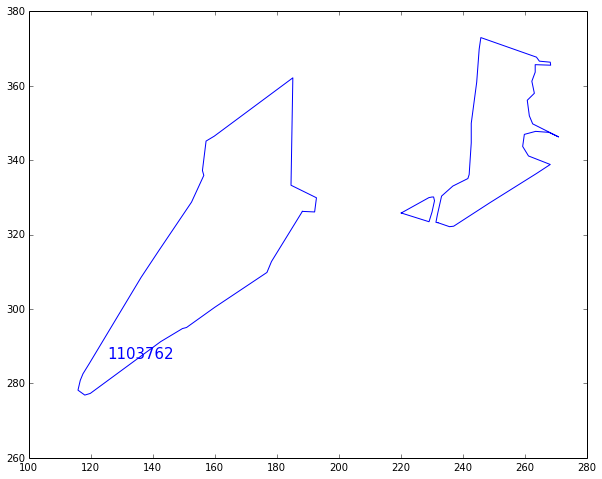

In [121]:
c="blue"
for seg in ann['segmentation']:
    x_loc , y_loc =process_raw_locs(seg)
    plt.plot(x_loc,y_loc,color = c)
plt.text(ann['bbox'][0]+10,ann['bbox'][1]+10,ann['id'], fontsize=15,color=c)

In [130]:
plt.text?

In [142]:
filtered_object_tbl

,id,image_id,name,object_id,worker_id,x_loc,y_loc
40,41,10,yellow banana,41,2,292,548
41,42,10,green banana,42,2,167,503
42,43,10,woman,43,2,193,343
43,44,10,woman,44,2,243,293
44,45,10,bird cage,45,2,82,181
45,46,10,woman,46,2,124,309
46,47,10,basket,47,2,192,156


In [ ]:
f

87229
88448
90761
1101595
1103762
1210601
1212101
1241400
1279115
1280745
24327
120400
671466
699378
707501
1084433
1137241
1394296
1397611
1425407
6775
134072
603158
34315
83580
1138372
1141144
1143802
1143975
1146656
1146705
1146851
1147365
327335
1970846
1154063
1156222
1581487
2127292
2197336
445554
630347
1710395
127510
163793
204560
212274
219005
397538
1246980
1334075
1372523
1385594
463958
467023
470153
1050612
1050827
1051359
1542292
1543882
1544192
1544712


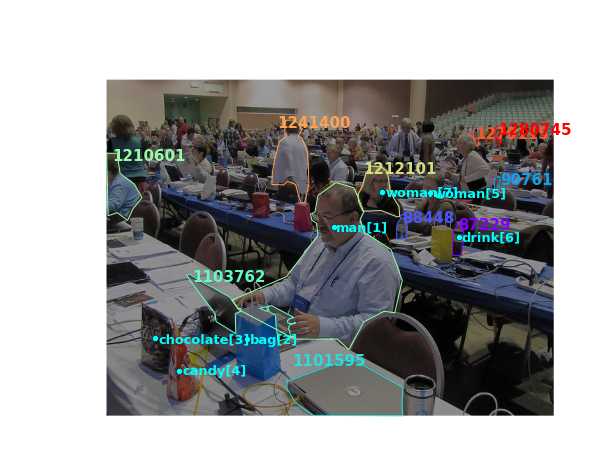

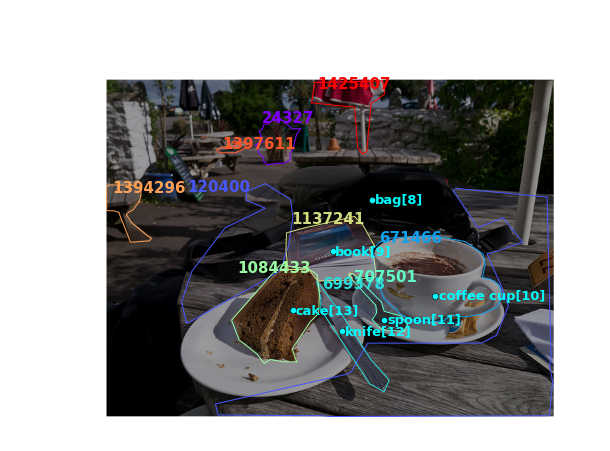

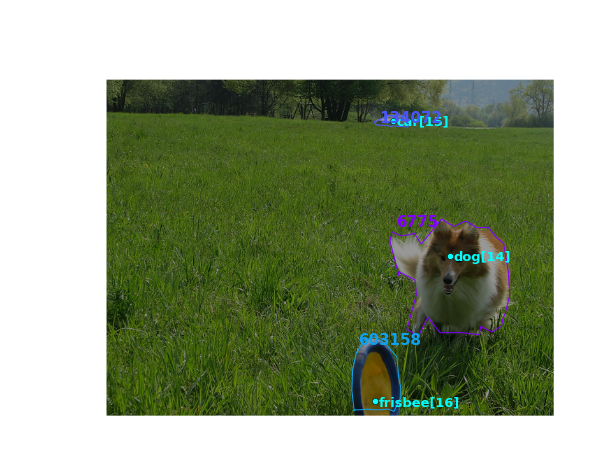

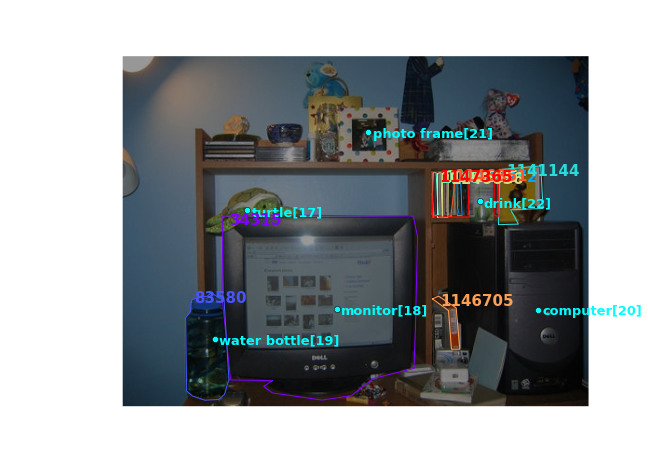

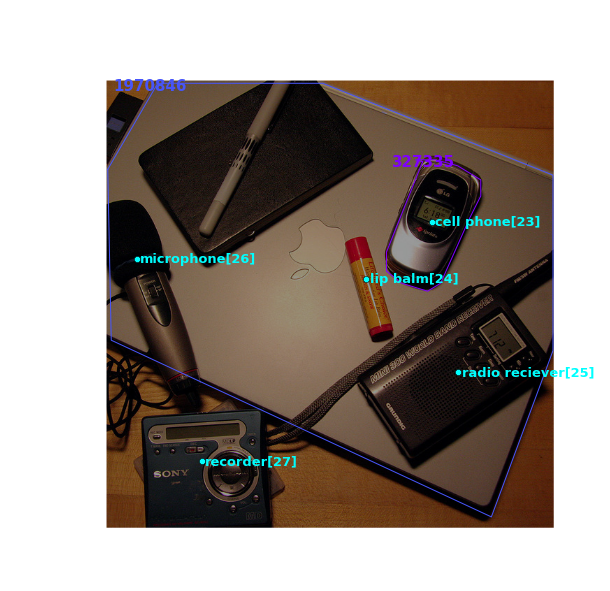

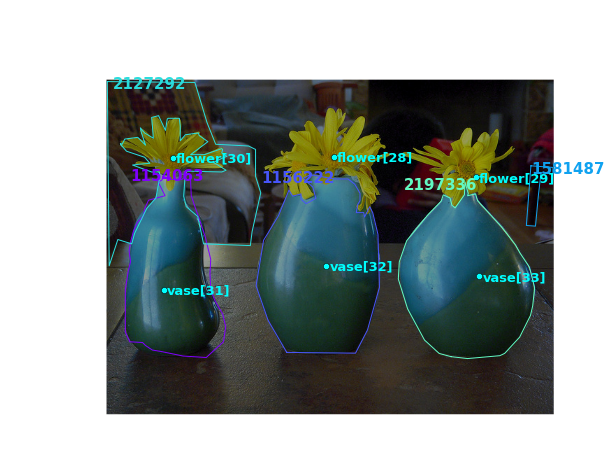

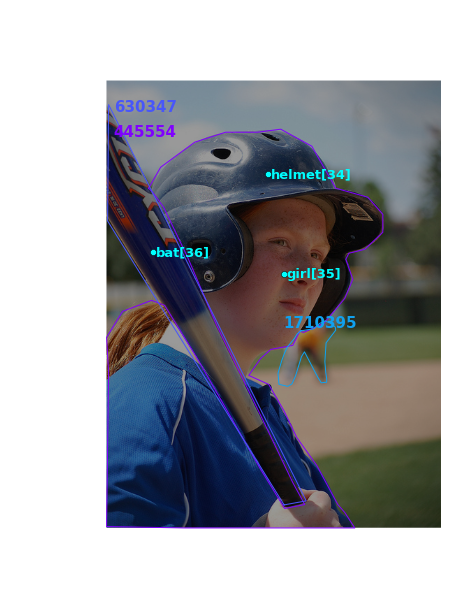

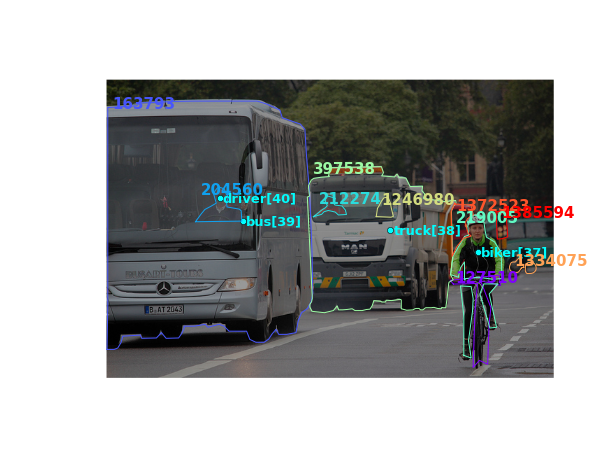

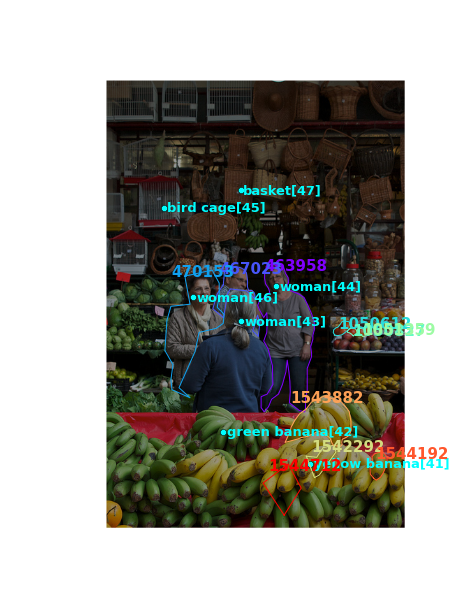

In [176]:
# Cross Matching with COCO annotations 
for i in np.arange(len(img_info)):
    img_name = img_info["filename"][i]
    if 'COCO' in img_name:
        fname = "../web-app/app/static/"+img_name+".png"
        imgf=0.6*mpimg.imread(fname)
        width,height = get_size(fname)
        filtered_object_tbl = object_tbl[object_tbl["image_id"]==i+1]

#         plt.axis("off")
#         plt.plot(filtered_object_tbl["x_loc"],filtered_object_tbl["y_loc"],'o',color="cyan")

        img_id = int(img_name.split('_')[-1])
        img = coco.loadImgs(img_id)[0]
        plt.figure(figsize =(10,10))
        plt.imshow(imgf); plt.axis('off')
        # Annotation from my own object table
        plt.plot(filtered_object_tbl["x_loc"],filtered_object_tbl["y_loc"],'o',color="cyan")        
        for name,oid, x,y in zip(filtered_object_tbl["name"],filtered_object_tbl["id"]\
                            ,filtered_object_tbl["x_loc"],filtered_object_tbl["y_loc"]):
            plt.text(x+5,y+5,name+"[{}]".format(oid), fontsize=13,weight="heavy",color='cyan')
        #COCO-Annotations
        annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
        anns = coco.loadAnns(annIds)
        colors=cm.rainbow(np.linspace(0,1,10))
        for ann,c in zip(anns,colors):
            for seg in ann['segmentation']:
                x_loc , y_loc =process_raw_locs(seg)
                plt.plot(x_loc,y_loc,color = c)
            print ann['id']
            plt.text(ann['bbox'][0]+10,ann['bbox'][1]+10,ann['id'], fontsize=15,weight="heavy", color=c)

In [154]:
ground_truth = pd.read_csv("../../data/object_ground_truth.csv")

In [175]:
for i in np.arange(len(img_info)):
    img_name = img_info["filename"][i]
    if 'COCO' in img_name:
        fname = "../web-app/app/static/"+img_name+".png"
        img=mpimg.imread(fname)
        width,height = get_size(fname)
        filtered_object_tbl = object_tbl[object_tbl["image_id"]==i+1]

        for oid,bbx_path,bby_path in zip(bb_info["object_id"],bb_info["x_locs"],bb_info["y_locs"]):
            if int(object_tbl[object_tbl.object_id==oid].image_id) ==i+1:
                x_locs,y_locs= process_raw_locs([bbx_path,bby_path])
#                 print majority_vote(x_locs,y_locs,width,height)
                ground_truth_match = ground_truth[ground_truth.id==str(oid)]
                COCO_id = int(ground_truth_match["COCO_annIds"])
                if COCO_id==-1:
                    #No BB for this object collected by MSCOCO
                    pass
                else: 
                    print COCO_id

1103762
87229
1212101
1212101
1212101
1103762
1212101
1212101
87229
1103762
1212101
1103762
87229
1212101
1212101
87229
1103762
1212101
87229
87229
1212101
1103762
87229
1212101
1103762
87229
87229
1212101
1103762
87229
1103762
87229
1103762
87229
1212101
87229
87229
1103762
1103762
1103762
1103762
1212101
1212101
1212101
87229
1212101
87229
1212101
1212101
87229
1212101
87229
1103762
1103762
87229
1212101
1103762
1212101
1103762
1103762
87229
87229
1212101
1212101
1212101
87229
1103762
1212101
1103762
87229
87229
1212101
1212101
1212101
1103762
1103762
87229
1103762
1212101
87229
1103762
1103762
87229
87229
1103762
1103762
87229
1103762
87229
1103762
1212101
87229
1212101
87229
1103762
87229
1103762
87229
87229
1212101
87229
1103762
1212101
87229
87229
1103762
1103762
1212101
87229
1103762
1212101
87229
1103762
1212101
1103762
1212101
1212101
1103762
1103762
1212101
1137241
1137241
1137241
1137241
1137241
1137241
1137241
1137241
1137241
1137241
1137241
1137241
1137241
1137241
1137241
